# 분류
## MNIST
MNIST는 미국 고딩들과 인구조사국 직원들이 손으로 쓴 7만개의 숫자 이미지 데이터셋이다. 이 데이터셋은 머신러닝 계의 Hello World라고 불릴 정도로 아주 유명하고 새로운 분류 알고리즘이 나오면 항상 이 데이터셋에서 성능을 평가한다. sckit-learn에서도 이 데이터셋을 다운로드 하기 위한 인터페이스가 이미 갖추어져 있다.

In [1]:
from shutil import copyfileobj
from six.moves import urllib
from sklearn.datasets.base import get_data_home
import os

def fetch_mnist(data_home=None):
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    data_home = get_data_home(data_home=data_home)
    data_home = os.path.join(data_home, 'mldata')
    if not os.path.exists(data_home):
        os.makedirs(data_home)
    mnist_save_path = os.path.join(data_home, "mnist-original.mat")
    if not os.path.exists(mnist_save_path):
        mnist_url = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_save_path, "wb") as matlab_file:
            copyfileobj(mnist_url, matlab_file)

- 사이킷런의 데이터셋은 아래와 같은 dict 구조를 가지고 있음.
    - 데이터셋을 설명하는 DESCR 키
    - 샘플이 행, 특성이 열로 구성된 배열을 가진 data 키
    - 레이블 배열을 담는 target 키

In [2]:
fetch_mnist()
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([0., 0., 0., ..., 9., 9., 9.])}

In [3]:
X, y = mnist['data'], mnist['target']
X.shape # 784 = 28*28

(70000, 784)

In [4]:
y.shape

(70000,)

- 이미지가 7만개 있고 특성이 784개인 이유는 28*28 이미지이기 때문이다.
- 각 특성은 0~255의 색을 의미함. (알파값만 있음)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [6]:
y[36000]

5.0

- **데이터를 보기전에 항상 테스트 세트를 만들고 따로 떼어놓아야 한다는 사실을 잊지 말자!**
- 이미 MNIST는 훈련 세트인 앞쪽 6만개 이미지와 테스트 세트 뒤쪽 만개로 나뉘어져 있음.

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

위 과정은 훈련 세트를 섰어서 모든 교차 검증 폴드가 비슷해지게 만드는 것임. (하나의 폴드라도 숫자가 누락되면 안 됨)
그리고 어떤 학습 알고리즘은 훈련 샘플의 순서에서 민감해서 비슷한 샘플이 연이어 나타나면 성능이 나빠진다. 그래서 데이터셋을 섞으면 문제를 방지할 수 있다.

## 이진 분류기 훈련
일단 숫자 5만 식별하는 문제로 단순화시켜서 생각해보자. 이 5 감지기는 5와 5아님을 구분하는 `binary classfier`의 예이다. 아래는 분류작업을 위한 타깃 벡터이다. 타깃 벡터를 만들고 나서 사이킷런의 `SGDClassfier`를 이용 **확률적 경사 학습법(Stochastic Gradient Descent)** 분류기로 시작해본다.

SGD는 한 번에 훈련 샘플을 독립적으로 처리하므로 큰 데이터셋을 호율적으로 처리하는 장점이 있다. 그래서 온라인 학습에 잘 들어맞는다.

In [9]:
y_train_5 = (y_train) == 5
y_test_5 = (y_test) == 5

from sklearn.linear_model import SGDClassifier

# 훈련하는 데 랜덤성을 사용함
sgd_clf = SGDClassifier(max_iter=5) # 책에서처럼 시드를 42 주니까 못 맞춰서.. 그냥 시드값을 디폴트로 줌.
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=5, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

# 성능 측정
## 교차 검증을 사용한 정확도 측정
사이킷런이 제공하는 기능보다 더 복잡한 교차 검증 기능이 필요할 경우 직접 구현하면 된다. 아래 코드는 사이킷런과 거의 같은 작업을 하면서 동일한 결과를 출력한다. `StratifiedKFold`는 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링을 수행한다. 

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # 0.927, 0.9619, 0.9435 출력

0.96455
0.96115
0.95375


In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96795, 0.9566 , 0.887  ])

K-겹 교차 검증은 훈련세트를 K개 (3개)의 폴드로 나누고 (cv=3) 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용한다는 것을 기억하자.

In [13]:
from sklearn.base import BaseEstimator

class Never5Classfier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classfier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91155, 0.9074 , 0.91   ])

정확도가 90퍼센트 이상이라 좋아보이지만 이 예제는 사실 정확도를 분류기의 성능 측정 지표로 선호하지 않는 다는 것을 보여준다. 왜 그런지는 나중에 나오는지는 모르겠지만 특히 불균형한 데이터셋을 다룰 때 (어떤 클랫가 다른 것보다 많은 경우) 그렇다고 한다.

## 오차 행렬
분류기의 성능을 평가하는 방법은 오차 행렬을 조사하는 것이 더 좋다고 한다. 기본적으로 A의 샘플이 B로 분류된 횟수를 세는 것이다. 예를 들어 숫자 5을 3으로 잘못 분류한 걸 보고 싶다면 오차 행렬의 5행 3열을 보면 된다. 오차 행렬을 만들려면 먼저 예측값을 만들어야 한다. 테스트 세트를 쓰지 말고 cross_val_predict()를 써보자.

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52930,  1649],
       [ 1320,  4101]])

위 행렬에서 행은 실제 클래스를 (5 아님 혹은 5) 열은 에측한 클래스를 나타냄. 즉 첫 행은 5가 아닌 이미지에 관한 것(`negative class`)으로 1행 1열은 `true negative` 1행 2열은 `false positivie`이다. 2행은(`positive class`) 에 대한 것으로 2행 1열은 (`true positive`)이고 2행 2열은 (`false positive`)이다.

간단하게 **5가 아니라고 맞춘 것(TN), 5인데 5가 아니라고 한것(FN), 5인 걸 맞춘 것(TP), 5가 아닌데 5라고 한 것(FP)** 라고 말할 수 있다. 이렇듯 오차 행렬은 많은 정보를 주지만 요약된 정보가 필요할 때도 있는데 첫 번째로 양성 예측의 정확도 즉 **정밀도(precision)**이다.

$$정밀도 = {TP \over TP + FP} $$

양성 샘플 하나만 에측하면 간단히 정밀도가 완벽해지지만 (무슨 말인지 생각해보니 그냥 하나만 예측하고 그걸 맞췄다 치면 1/(1+0))이므로 100퍼센트의 정밀도를 가진다, TP=1, FP=0이므로) 하지만 당연히 다른 애들은 무시한 결괴이므로 말이 안 된다. (적절한 예가 아닌 것 같은데?)

그래서 **재현율(recall)** 이라는 지표도 쓴고 한다. 재현율이란 분류기가 정확하게 감지한 양성 샘플의 비율로 **민감도(sensitivity)** 혹은 **진짜 양성 비율(true positive rate, TPR)** 이라고도 부른다.

$$재현율 = {TP \over TP + FN} $$

사이킷런은 정밀도와 재현율을 포함해서 분류기의 지표를 계산하는 함수를 제공하고 있다.

In [16]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7132173913043478

In [17]:
recall_score(y_train_5, y_train_pred)

0.7565024903154399

정밀도와 재현율을 $F_{1}$ 점수로 만들면 두 분류기를 만들 때 편하다고 한다. $F_{1}$ 점수는 정밀도와 재현율의 **조화 평균(harmoonic mean)** 이다.

$$ F_{1} = \frac {2}{\frac{1}{정밀도} + \frac{1}{재현율}} = 2 * \frac{정밀도*재현율}{정밀도+재현율} = \frac{TP}{TP+\frac{FN+FP}{2}} $$

$F_{1}$ 점수를 계산하려면 `f1_score()` 함수를 쓰자. 정밀도와 재현율이 모두 높으면 점수가 높다 (조화평균의 정의를 생각해보면 당연한 것) 하지만 점수가 높은 것이 항상 바람직한 것은 아니고 문제에 따라 어느 수치가 더 중요할 수가 있다. 그리고 세상의 이치에 따라 당연히 트레이드오프가 있어서 정밀도를 올리려고 하면 재현율이 줄어들게 되고 반대도 마찬가지다.

In [18]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7342225405066689

## 정밀도/재현율 트레이드오프
SGDClassifier는 결정 함수(decision fuction)으로 각 샘플의 점수를 계산한다. 임곗값보다 크면 양성 아니면 음성으로 할당한다. 책의 내용을 읽어보면 점수가 높은 순으로 샘플들이 순차적으로 정리되어 있기 때문에 임곗값에 변화에 따라 맞추거나 틀린 샘플의 갯수가 변화하면서 정확도와 재현율도 올라가거나 내려가거나 하므로 트레이드오프라고 한 것 같다. 사이킷런에서는 임겟값을 정할 수는 없지만 예측에 쓴 점수는 볼 수 있다.

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

SGDClassifier의 임곗값이 0이라 predict와 같은 결과를 반환한다.

In [20]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

적절한 임곗값을 정하기 위해서는 교차검증을 통해 훈련 세트의 모든 샘플의 점수를 구하고 나서 예측 결과가 아니라 결정 점수를 반환하도록 해야 한다.

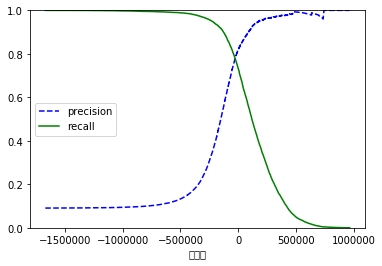

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recall')
    plt.xlabel('임곗값')
    plt.legend(loc='center left')
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

왜 정밀도 커브는 울퉁불퉁하지만 재현율은 일정하냐면 임곗값을 올리더라도 정밀도가 낮아질때가 있기 때문이다. (임곗값을 올렸는데 잘못된 숫자를 맞추는 경우가 있기 때문) 하지만 재현도는 임곗값을 올릴 수록 줄어들 수 밖에 없다(잘못된 숫자를 맞추나 바른 숫자를 틀리나 결국 재현도는 줄어드므로?)

따라서 작업에 맞는 최선의 정밀도/재현율 트레이드오프를 만드는 임곗값을 선택하면 된다. 아래와 같은 그림을 그리는 것이 작업에 도움이 많이 된다.

Text(0,0.5,'precision')

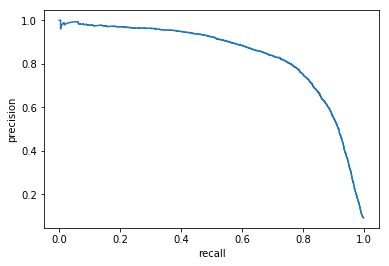

In [22]:
# 이 그래프 그리는 코드는 없어서 그냥 직접 짰다

plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel('recall')
plt.ylabel('precision')

In [23]:
from sklearn.metrics import average_precision_score
average_precision_score(y_train_5, y_scores)

0.8382718665463307

In [24]:
y_train_pred_90 = (y_scores > 110000) # 임겟값을 어떻게 찾는건지 모르곘는데 그래프가 대충 11만에서 끊겨서 그렇게 정함
y_train_pred_90

array([False, False, False, ..., False, False, False])

In [25]:
precision_score(y_train_5, y_train_pred_90)

0.9158480681074002

In [26]:
recall_score(y_train_5, y_train_pred_90)

0.5159564655967533

- 임곗값을 대충 높게 하면 정밀도가 높은 분류기는 쉽게 만들 수 있지만 재현율이 너무 낮으면 별로 유용하지 않음
- **따라서 누군가 정밀도를 높이자고 할때는 재현율을 얼마로 하고 싶은건지 물어봐야 한다!!**

## ROC곡선

**수신기 조작 특성(receiver operating characteristic, ROC)** 곡선도 이진 분류에서 널리 사용함. 정밀도/재현율 곡선과 비슷하지만 ROC 곡선은 **거짓 양성 비율(false positive rate, FPR)**에 대한 **진짜 양성 비율(true positive rate, TPR)** 의 곡선이다. 즉 양성으로 잘못 분류된 음성의 비율이 FPR임. 이는 1-TNR(true negative rate)를 뺀 값이다. TNR을 **특이도(specifity)** 라고도 한다. 따라서 ROC 곡선은 민감도(재현율)에 대한 1-특이도 그래프다.

- TPR: 재현율
- FPR: 5가 아닌데 5라고 분류된 애들의 비율

- FPR과 TNR의 관계
$$ FPR = \frac{FP}{FP+TN} = \frac{FP+TN-TN}{FP+TN} = 1-\frac{TN}{FP+TN} = 1 - TNR  $$

- ROC 곡선도 트레이드오프가 있음. 재현율이 높을 수록 FPR이 올라가기 때문이다.
- 곡선 아래의 면적(AUC)를 측정하면 분류기들을 비교할 수 있다.
- 완벽한 분류기는 ROC의 AUC가 1이다.
- 일반적으로 양성 클래스가 드물거나 FN이 FP보다 중요하면 PR 곡선을 아니면 ROC 커브를 쓴다.
- TPR 곡선은 성능 개선 여지가 얼마나 되는지 보여준다.

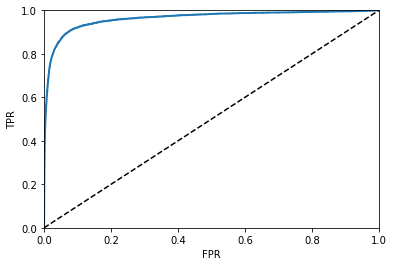

In [27]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
plot_roc_curve(fpr, tpr)

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9630650451331344

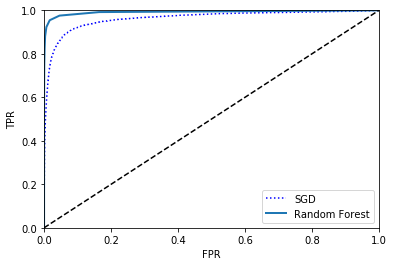

In [29]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤 포레스트는 decison_function이 없어서 predict_proba메서드를 사용

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

# 곡선을 그리려면 확률이 아니라 점수가 필요하므로
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')

In [30]:
roc_auc_score(y_train_5, y_scores_forest)

0.9921341947536306

## 다중 분류
지금까지 두 개의 클래스를 구별하는 걸 했다면 다중 분류기는 두 개를 넘는 클래스를 구분할 수 있다.

- 일대다(OvA) 전략
    - 숫자별 이진 분류기 (0~9)를 각각 훈련시키는 방식
    - 이미지를 분류할 때 각 분류기의 결정 점수 중 가장 높은 것을 선택하기
- 일대일(OvO) 전략
    - 0,1 구별, 0,2 구별, 1,2 구별 등 숫자의 조합마다 각각 이진 분류기를 훈련시키는 방식. 클래스가 N개라면 N의 조합의 수만큼의 분류기가 필요하며 MNIST 문제는 45개를 훈련시켜야 한다.
    
SVM 같은 알고리즘은 훈련 세트의 크기에 민감하므로 작은 훈련 세트에서 많은 분류기를 훈련시키는 쪽이 빠르므르 OvO를 선호하지만 나머지는 OvA를 선호한다.

In [31]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([0.])

5를 구별하기 위한 타깃 클래스 대신 전체 클래스를 이용해서 훈련 시킴. 내부적으로는 사이킷런이 실제로 10개를 훈련시키고 가각의 결정 점수를 얻어서 점수가 가장 높은 클래스를 선택한다.

In [32]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores # 가장 높은 점수가 클래스 5에 해당하는 값

array([[ -79295.51248445, -601182.47718182, -406761.43304329,
        -107744.8911424 , -437531.15183766,  -94195.48768066,
        -777372.88055881, -456075.02989016, -635124.12814885,
        -692098.14108748]])

In [33]:
np.argmax(some_digit_scores)
sgd_clf.classes_
sgd_clf.classes_[5]

5.0

In [34]:
from sklearn.multiclass import OneVsOneClassifier
# OvO나 OvA를 사용하도록 강제하는 코드 OvA를 강제하려면 OneVsRestClassifier 사용
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])
len(ovo_clf.estimators_)


45

In [35]:
# 랜덤 포레스트 분류기 훈련
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

랜덤 포레스트 분류기는 직접 샘플을 다중 클래스로 분류할 수 있으므로 위와 같이 OvO나 OvA를 강제하는 코드를 짤 필요가 없음. `predict_proba()` 메서드를 호출하면 분류기가 샘플에 부여한 클래스별 확률을 얻을 수 있음

In [36]:
forest_clf.predict_proba([some_digit])
# 0.7이란 값은 이미지가 5일 가능성이 70퍼센트라는 뜻

array([[0. , 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0.1]])

In [37]:
# 교차 검증으로 분류기를 평가
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.86887622, 0.88184409, 0.87428114])

In [38]:
# 입력의 스케일을 조정해서 90퍼센트 이상으로 정확도 높이기
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.90871826, 0.90969548, 0.906686  ])

## 에러 분석

1. 만들어진 에러의 종류를 분석한다.

In [39]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5738,    3,   20,   10,    9,   48,   43,   10,   39,    3],
       [   2, 6480,   47,   30,    6,   41,    5,   13,  109,    9],
       [  54,   36, 5325,  101,   76,   25,   99,   59,  168,   15],
       [  50,   44,  143, 5337,    2,  233,   37,   53,  141,   91],
       [  16,   29,   29,    9, 5378,   10,   58,   40,   83,  190],
       [  75,   48,   33,  186,   77, 4596,  101,   28,  186,   91],
       [  33,   30,   42,    2,   40,   96, 5616,    6,   53,    0],
       [  20,   18,   66,   42,   51,   11,    6, 5826,   18,  207],
       [  53,  164,   68,  168,   17,  145,   63,   29, 5019,  125],
       [  44,   37,   27,   91,  172,   38,    2,  210,   73, 5255]])

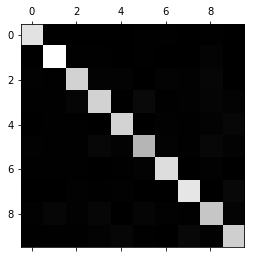

In [40]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

이 오차 행렬은 하얀색이 대각선을 보이므로 좋아 보인다. 하지만 5부분이 어두워 보이는 걸로 봐서 잘 분류하지 못하는 것 같다. 에러에 집중하기 위해 다른 항목은 그대로 유지하고 주대각선만 0으로 채워서 그래프를 그립니다. (큰 값을 흰색 작은 값은 검은색으로)

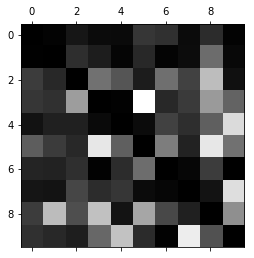

In [41]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

행은 실제 클래스고 열은 에측한 클래스를 나타낸다. 8~9 부분에 발근 사각형이 많으므로 잘못 분류된 숫자들이라는 걸 파악할 수 있다. 반면 1~2 부분은 상대적으로 검으므로 잘 예측된 숫자들이라는 걸 알 수 있다.

In [42]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [43]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

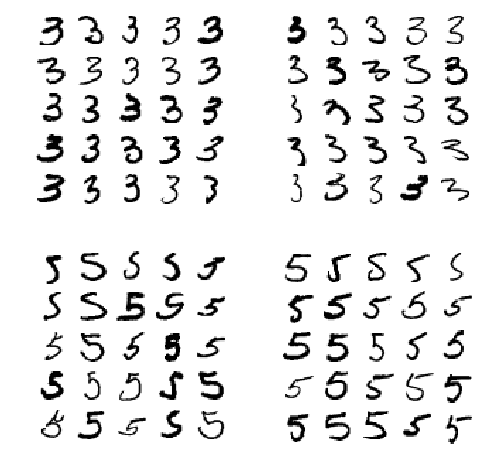

In [44]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

몇몇은 사람이 봐도 헷갈리는 게 있지만 대부분은 에러를 이해하기 힘듬. 그 이유는 선형 모델인 SGDClassifier를 사용했기 때문이다. 선형 분류기는 클래스마다 픽셀에 가중치를 주고 새로운 이미지는 단순히 픽셀 강도의 가중치 합을 점수로 계산한다. 따라서 3과 5는 단순히 몇개 픽셀만 다르므로 쉽게 혼동하게 된다. 분류기는 또 이미지의 위치나 회전에 민감하므로 이미지를 중앙에 위치시키고 회전되어 있지 않게 전처리하는 것도 중요하다.

## 다중 레이블 분류
얼굴 인식 분류기를 개발한다고 생각해보면 같은 사진에 여러 명이 등장할 때가 있을 것이다. 이럴 때는 당연히 사람마다 레이블이 할당되야 하므로 어떤 사람이 있는지 없는 지 여부를 출력하도록 구현되어야 할 것이다. 이처럼 여러개의 이진 레이블을 출력하는 분류 시스템을 다중 레이블 분류 시스템이라고 한다.

In [45]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

y_multilabel 배열은 각 수자 이미지에 두개의 타깃 레이블이 담겨있다. 첫번째는 7이상의 숫자가 두 번째는 홀수인 숫자들을 나타낸다. 이 때 분류기를 만들고 위 배열을 통해서 훈련 시킨다. (KNeighborsClassifier는 다중 레이블 분류를 지원하나 모두 그런건 아님)

In [46]:
knn_clf.predict([some_digit]) # 5는 7보다 작고 홀수이므로 맞게 예측함

array([[False,  True]])

In [48]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9768160188763517

위 코드는 모든 레이블의 가중치가 같다고 가정한 것이지만 실제는 그렇지 않다. 에를 들어 어떤 사람의 사진이 다른 사람보다 많다면 그 사람 사진에 대한 분류기의 점수가 더 가중치가 높을 것이다. 간단히 레이블에 클래스의 **지지도(support)** (타깃 레이블에 속한 샘플 수)를 가중치로 준다. 위의 코드에서는 **average='weighted** 로 설정가능하다.

## 다중 출력 분류
**다중 출력 다중 클래스 분류(multioutput-multiclass classification)** 또는 간단히 **다중 출력 분류(multioutput classification)** 은 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있게 일반화한 것(값을 두 개 이상 가질 수 있음)


In [49]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test = noise
y_train_mod = X_train
y_test_mod = X_test

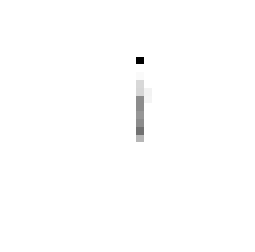

In [51]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[5]])
plot_digit(clean_digit)

## 연습문제 1
정확도 97퍼센트인 분류기 만들기.

In [53]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [54]:
cross_val_score(knn_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.96940612, 0.96814841, 0.96679502])